<a href="https://colab.research.google.com/github/umd-fire-coml/2022-t3-vector-quantization/blob/Final-Notebook-Push/VQ_VAE_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-probability


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf


In [ ]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [ ]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(140,1))
    x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv1D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv1DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [ ]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(140,1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 140, 1)]          0         
                                                                 
 encoder (Functional)        (None, 35, 16)            7376      
                                                                 
 vector_quantizer (VectorQua  (None, 35, 16)           1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 140, 1)            9409      
                                                                 
Total params: 17,809
Trainable params: 17,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [ ]:
!git clone https://github.com/mdeff/fma.git


Cloning into 'fma'...
remote: Enumerating objects: 823, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 823 (delta 6), reused 10 (delta 3), pack-reused 808
Receiving objects: 100% (823/823), 4.08 MiB | 25.35 MiB/s, done.
Resolving deltas: 100% (528/528), done.


In [ ]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  23.1M      0  0:00:14  0:00:14 --:--:-- 26.3M


In [ ]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 88 7323M   88 6459M    0     0  26.0M      0  0:04:40  0:04:07  0:00:33 26.4M^C


In [ ]:
mkdir audio
cd audio

In [ ]:
!echo "f0df49ffe5f2a6008d7dc83c6915b31835dfe733  fma_metadata.zip" | sha1sum -c -
!7z e fma_metadata.zip

fma_metadata.zip: OK

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 358412441 bytes (342 MiB)

Extracting archive: fma_metadata.zip
--
Path = fma_metadata.zip
Type = zip
Physical Size = 358412441

  0%      0% 4 - fma_metadata/raw_albums.csv                                      1% 4 - fma_metadata/raw_albums.csv                                      1% 5        1% 5 - fma_metadata/raw_artists.csv                                       2% 5 - fma_metadata/raw_artists.csv                         

In [ ]:
cd fma

/content/fma


In [ ]:
!pip install py7zr
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 2.3 MB 11.0 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 357 kB 52.7 MB/s 
     |████████████████████████████████| 378 kB 51.0 MB/s 
     |████████████████████████████████| 139 kB 64.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

import utils

In [ ]:
cd ..

/content


In [ ]:
tracks = utils.load('tracks.csv')
features = utils.load('features.csv')
echonest = utils.load('echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

In [ ]:
print(features['mfcc'].shape)


(106574, 140)


In [ ]:
import numpy as np

print(np.newaxis is None)


True


In [198]:
x_train = features['mfcc'].to_numpy()
x_test = features['mfcc'].to_numpy()

In [197]:
import librosa

In [199]:
x_train = x_train[0:100001,]
x_test = x_test[100001:106574,]
x_test.shape

(6573, 140)

In [105]:

x_train = np.expand_dims(x_train, -1)
#x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
#x_test = np.expand_dims(x_test, -1)
#x_train_scaled = (x_train / 255.0) - 0.5
#x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

x_train.shape, x_test.shape


((100001, 140, 1), (6573, 140, 1))

In [109]:
x_train.shape

(100001, 140, 1)

In [ ]:
mkdir ecpoch_data

In [106]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

#from keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('/ecpoch_data' , save_freq = 'epoch', 
 #                            save_weights_only = False)
#build(x_train.shape)
#vqvae_trainer.call()
vqvae_trainer.fit(x_train, epochs=30, batch_size=128) #, callbacks = [checkpoint])


Epoch 1/30
782/782 [==============================] - 43s 53ms/step - loss: 1777855206.4938 - reconstruction_loss: 52571.2734 - vqvae_loss: 1777799018.0000
Epoch 2/30
782/782 [==============================] - 40s 51ms/step - loss: 12642361482.6258 - reconstruction_loss: 35624.4766 - vqvae_loss: 12642319281.5326
Epoch 3/30
782/782 [==============================] - 41s 52ms/step - loss: 8000942155.8519 - reconstruction_loss: 28418.6875 - vqvae_loss: 8000913181.7522
Epoch 4/30
782/782 [==============================] - 39s 50ms/step - loss: 6528723077.3946 - reconstruction_loss: 23053.9824 - vqvae_loss: 6528694423.3768
Epoch 5/30
782/782 [==============================] - 40s 52ms/step - loss: 1383967741.8748 - reconstruction_loss: 14855.8506 - vqvae_loss: 1383950162.0639
Epoch 6/30
782/782 [==============================] - 40s 51ms/step - loss: 805671677.1392 - reconstruction_loss: 13440.3066 - vqvae_loss: 805654347.6884
Epoch 7/30
782/782 [==============================] - 38s 48ms/s

KeyboardInterrupt: ignored

In [110]:
trained_vqvae_model = vqvae_trainer.vqvae
#idx = np.random.choice(len(x_test), 10)
test_images = x_train
reconstructions_test = trained_vqvae_model.predict(test_images)



3126/3126 [==============================] - 32s 10ms/step


3126/3126 [==============================] - 11s 4ms/step


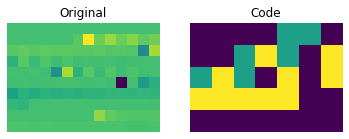

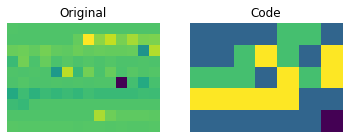

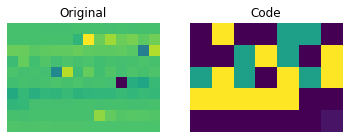

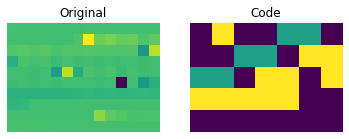

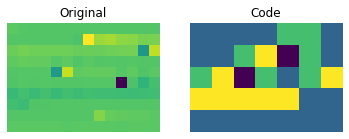

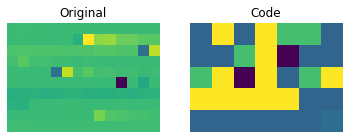

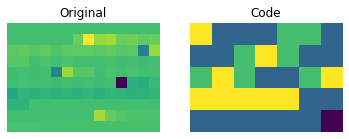

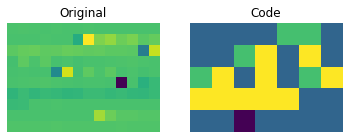

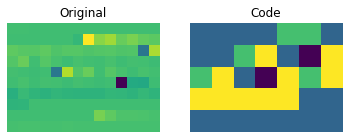

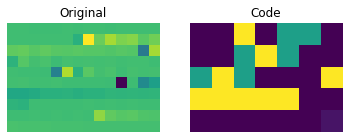

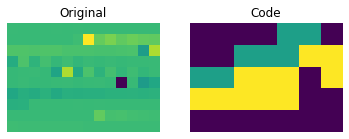

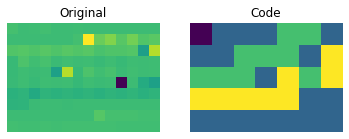

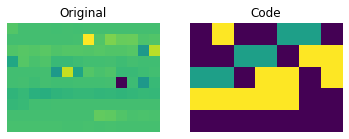

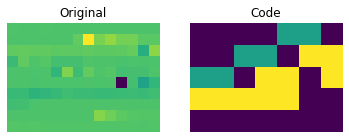

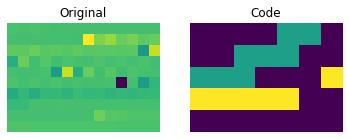

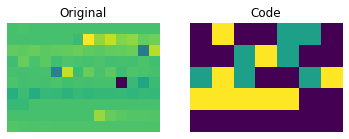

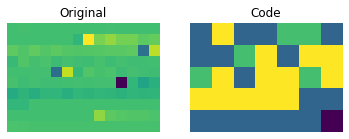

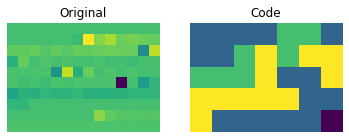

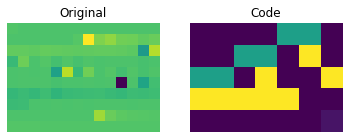

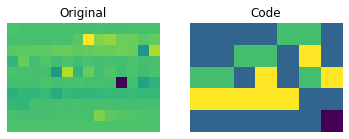

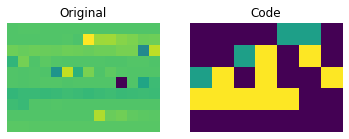

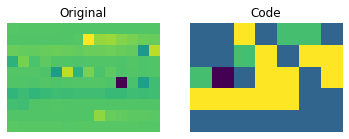

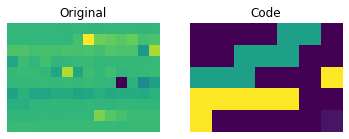

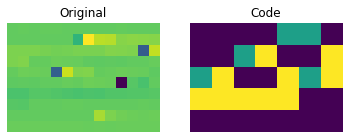

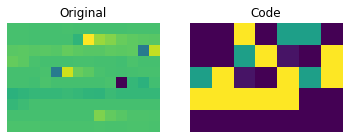

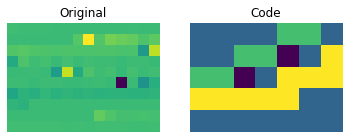

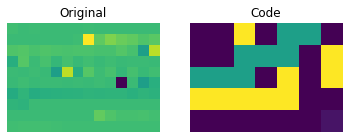

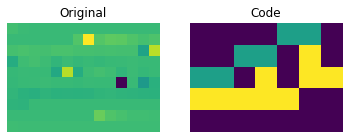

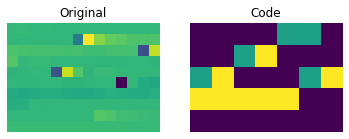

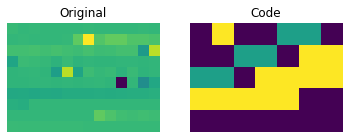

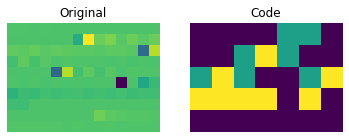

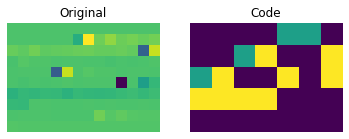

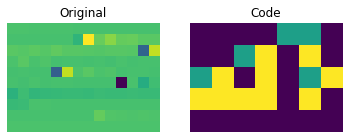

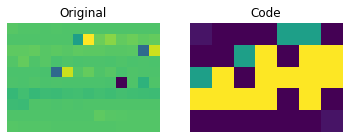

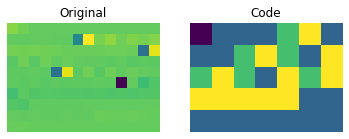

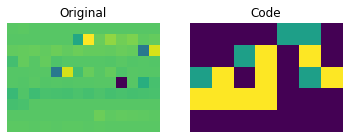

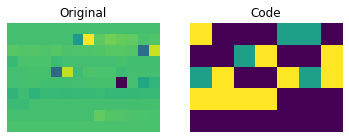

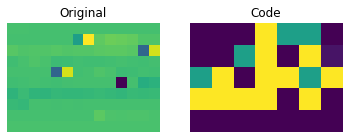

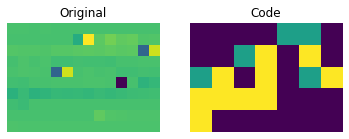

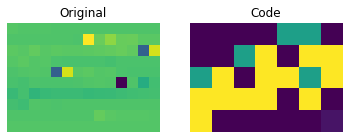

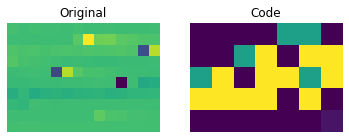

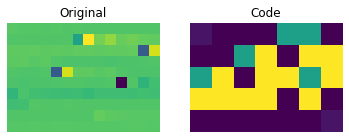

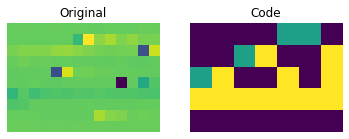

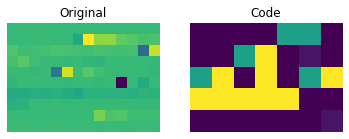

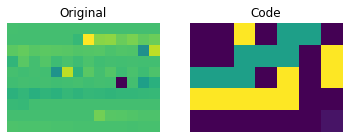

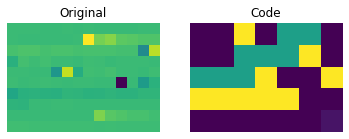

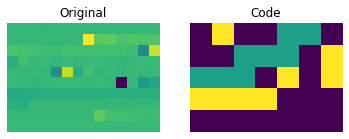

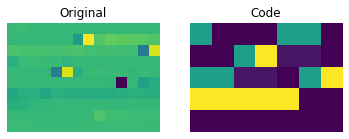

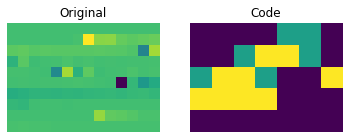

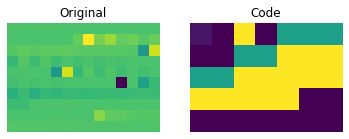

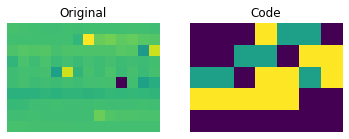

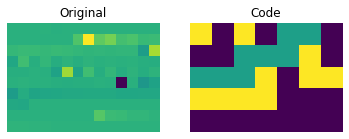

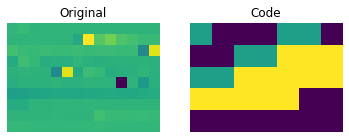

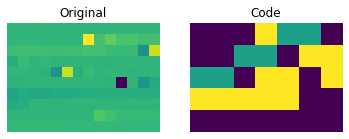

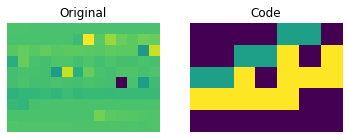

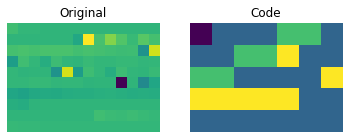

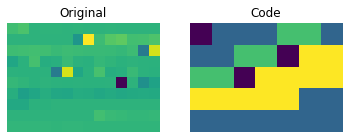

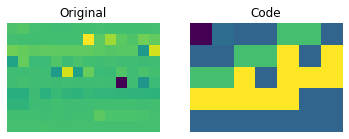

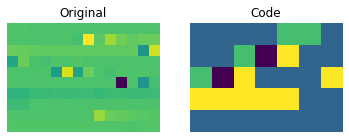

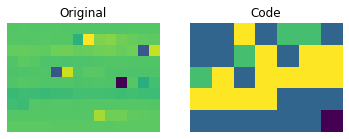

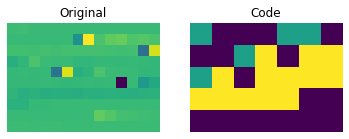

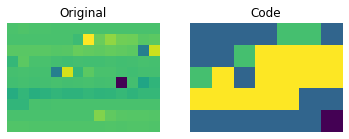

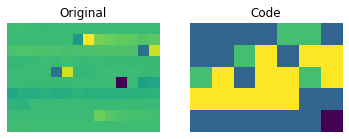

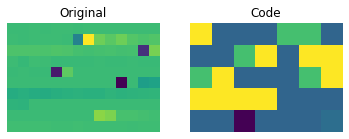

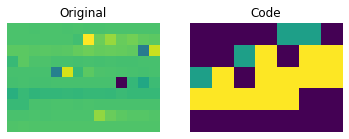

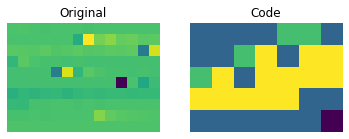

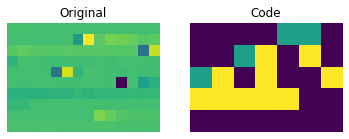

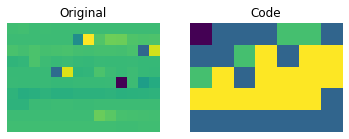

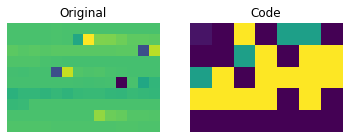

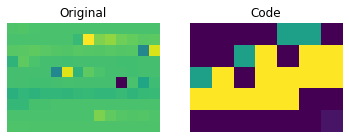

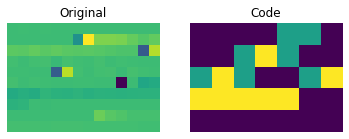

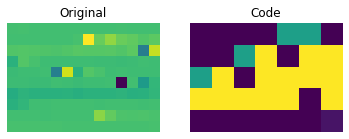

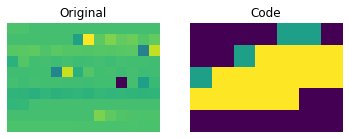

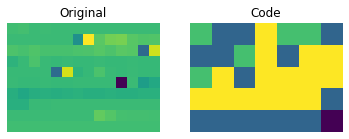

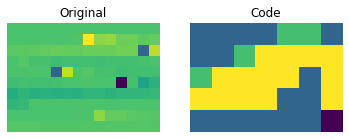

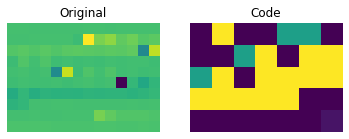

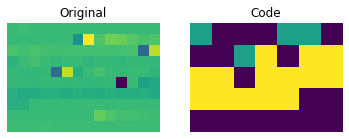

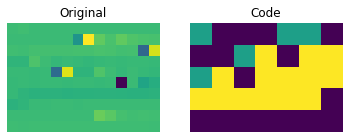

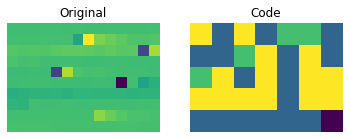

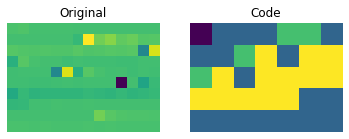

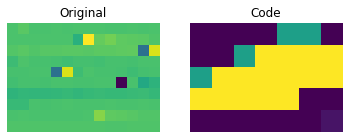

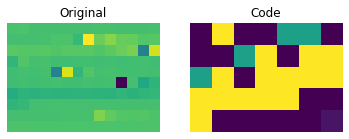

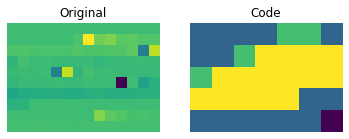

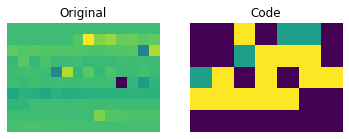

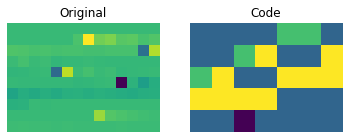

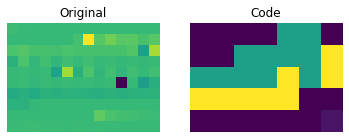

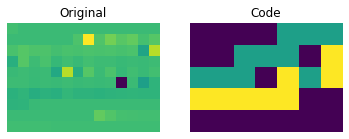

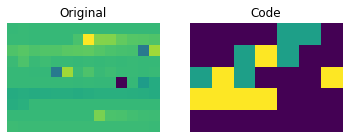

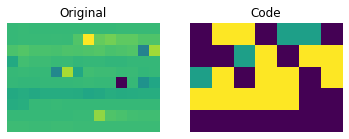

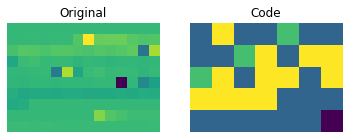

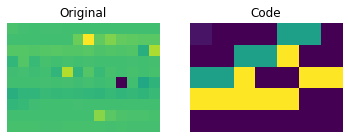

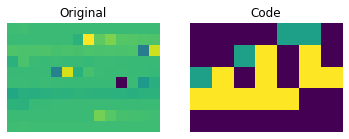

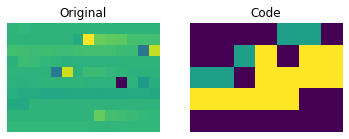

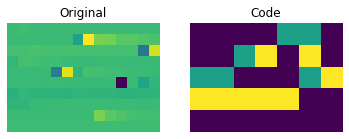

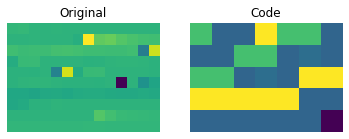

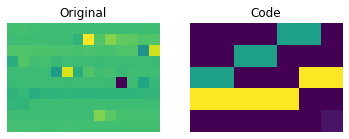

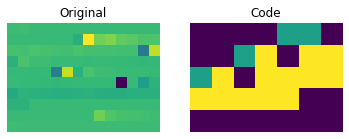

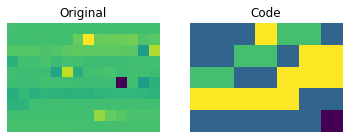

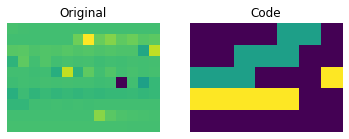

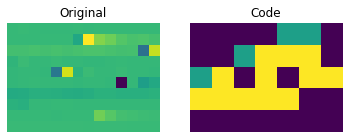

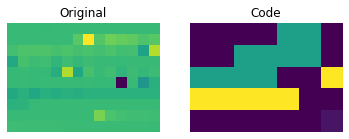

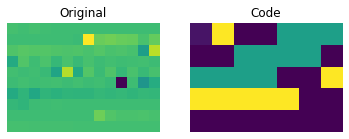

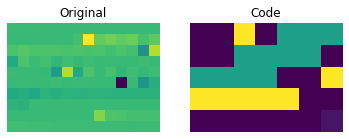

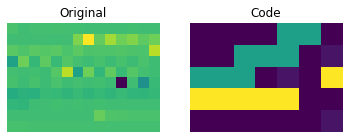

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [111]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].reshape(10,14))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i].reshape(5,7))
    plt.title("Code")
    plt.axis("off")
    plt.show()


In [112]:
codebook_indices.shape


(100001, 35)

In [114]:
trained_vqvae_model1 = vqvae_trainer.vqvae
#idx = np.random.choice(len(x_test), 10)
test_images1 = x_test
reconstructions_test1 = trained_vqvae_model1.predict(test_images1)

206/206 [==============================] - 2s 10ms/step


206/206 [==============================] - 1s 3ms/step


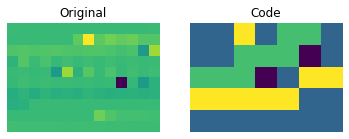

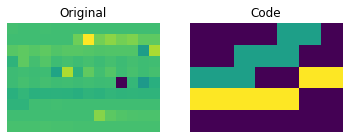

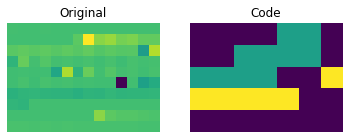

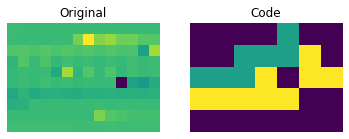

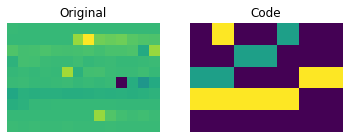

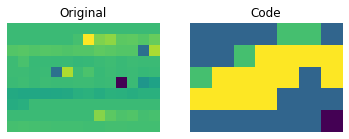

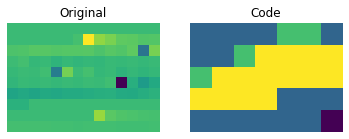

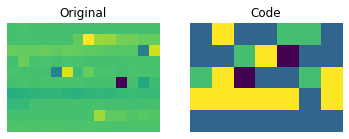

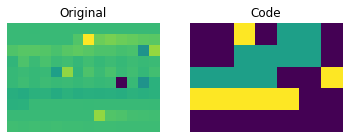

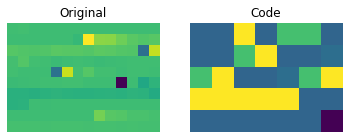

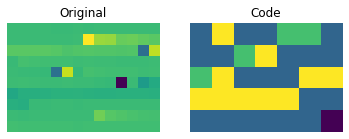

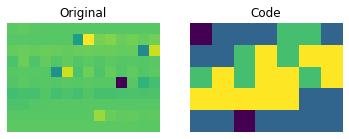

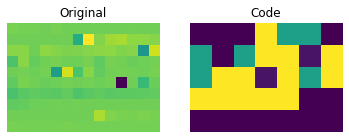

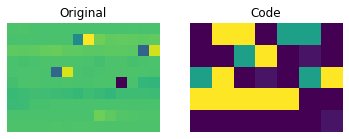

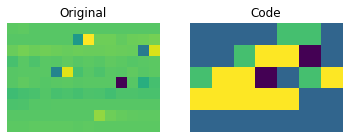

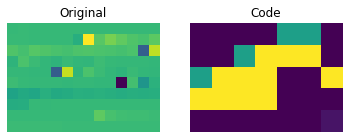

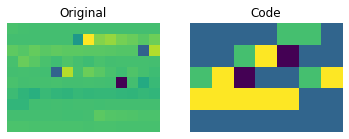

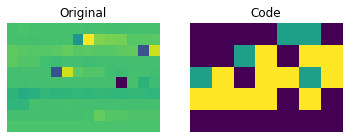

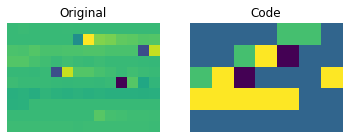

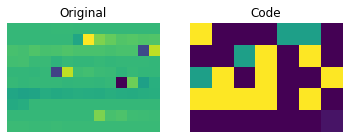

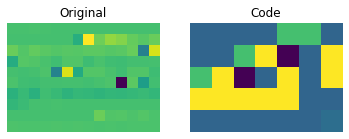

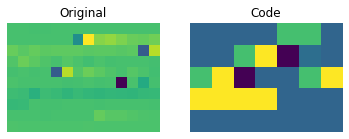

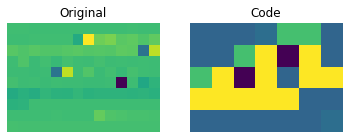

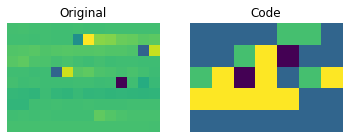

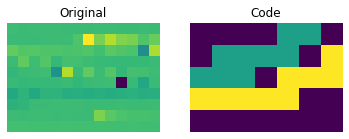

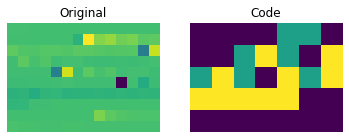

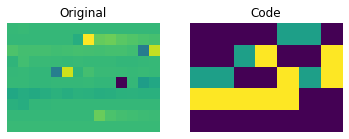

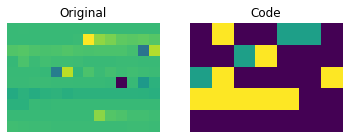

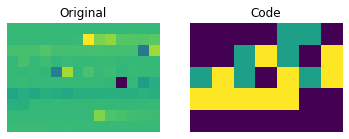

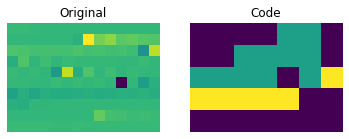

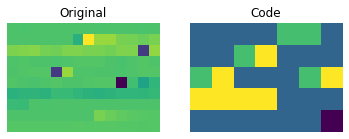

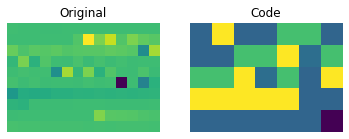

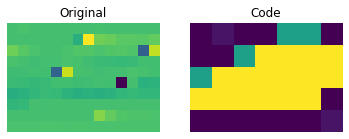

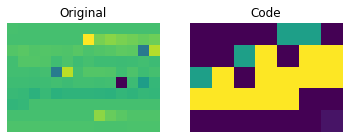

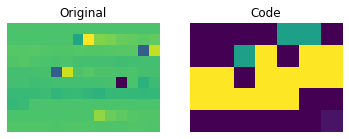

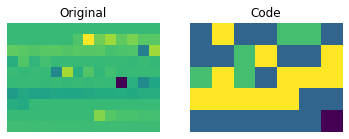

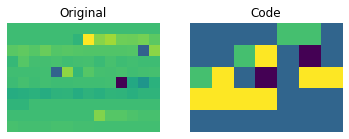

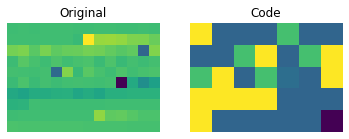

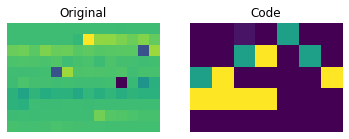

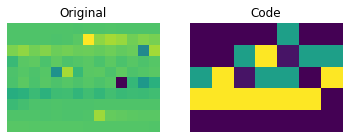

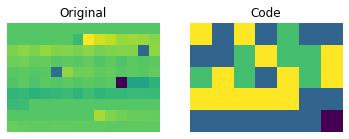

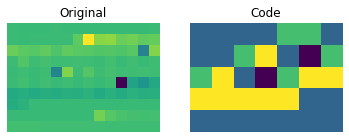

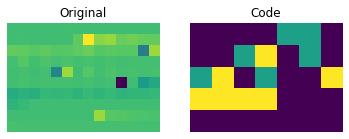

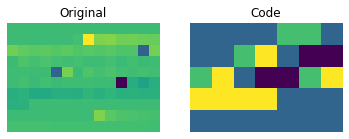

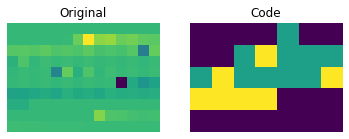

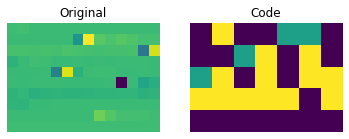

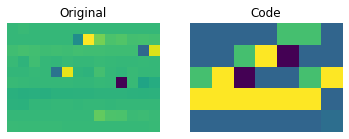

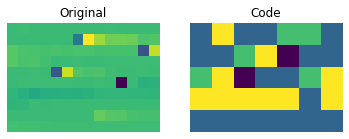

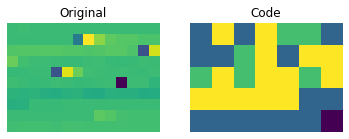

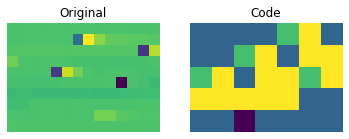

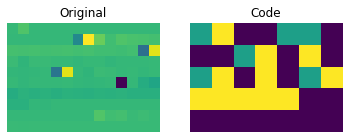

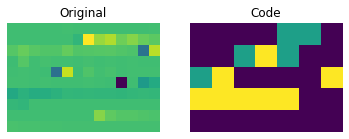

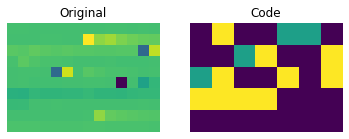

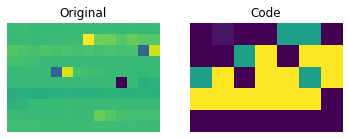

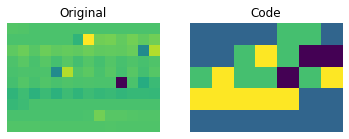

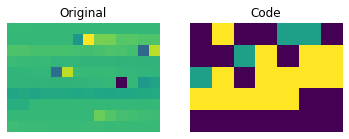

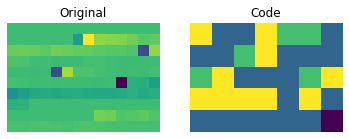

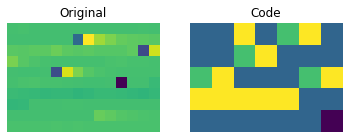

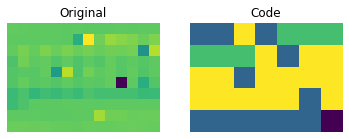

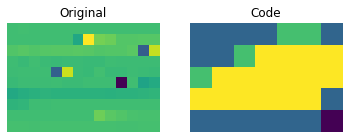

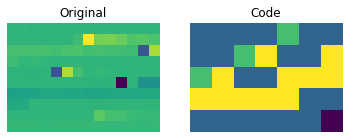

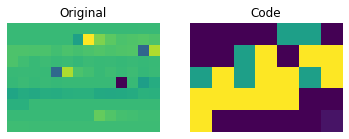

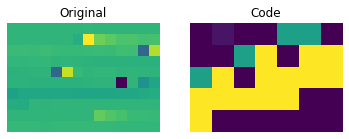

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [115]:
encoder1 = vqvae_trainer.vqvae.get_layer("encoder")
quantizer1 = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs1 = encoder1.predict(test_images1)
flat_enc_outputs1 = encoded_outputs1.reshape(-1, encoded_outputs1.shape[-1])
codebook_indices1 = quantizer1.get_code_indices(flat_enc_outputs1)
codebook_indices1 = codebook_indices1.numpy().reshape(encoded_outputs1.shape[:-1])

for i in range(len(test_images1)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images1[i].reshape(10,14))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices1[i].reshape(5,7))
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [154]:
codebook_indices1.shape

(6573, 35)

In [155]:
print(codebook_indices1[0])

[ 76  76 115  76  98  98  76  76  76  98  98  98  57  76  98  98  98  57
  76 115 115 115 115 115 115 115  76  76  76  76  76  76  76  76  76]


In [158]:
print(abs(np.sum(codebook_indices[0])-np.sum(codebook_indices1[0])))

72


In [172]:
arr1 = np.array([])
for i in range(len(codebook_indices1)):
  x = 999999999999999999999
  m = 0;
  for j in range(len(codebook_indices)):
    if x == 0:
      break
    y = np.sum(codebook_indices[j])-np.sum(codebook_indices1[i])
    if x > abs(y):
      x = abs(y)
      m = j
    #arr1 = np.append(arr1,abs(sum(codebook_indices[j])-sum(codebook_indices1[i])))
  #print(np.argmin(arr1))
  arr1 = np.append(arr1,m)
  #print(arr1)
print(arr1)

[ 840.  109.  800. ...   93.   10. 1492.]


In [235]:
user_input = 105297 #@param {type:"slider", min:100000, max:106570, step:1}
unser_input1 = user_input
user_input-=100000

index = arr1[user_input]
index=int(index)
print(index)
#print(tracks)
results = tracks['track', 'title'].to_numpy()
#results = features['mfcc'].to_numpy
#results = results[index:index+1,]
#print(tracks)
print(results[user_input] + ' is similar to ' +results[index])

1
I Knew a Women is similar to Electric Ave
